In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1770]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import sklearn.utils as ut 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

### Load data

In [2085]:
df = pd.read_csv("Data/data_daily/dataset_daily.csv")
df.head(2)

,Date,Open_USD_CHF,Open_CHF_EUR,Open_CHF_GBP,Open_CHF_JPY,Open_CHF_CAD,Open_BondCH1m,Open_BondCH2y,Open_BondCH10y,Open_SMI,Open_USD_JPY,Open_USD_EUR,Open_USD_GBP,Open_USD_CAD,Open_BondUS1m,Open_BondUS2y,Open_BondUS10y,Open_SP500
0,2001-12-27,1.6886,0.6723,0.4071,77.46,0.9477,1.68,2.011,3.460,6392.1,130.82,1.1356,0.6876,1.6010,1.751,3.307,5.072,1149.4
1,2001-12-28,1.6776,0.6745,0.4106,78.48,0.9520,1.68,2.059,3.474,6430.6,131.68,1.1319,0.6887,1.5981,1.720,3.169,5.113,1157.1


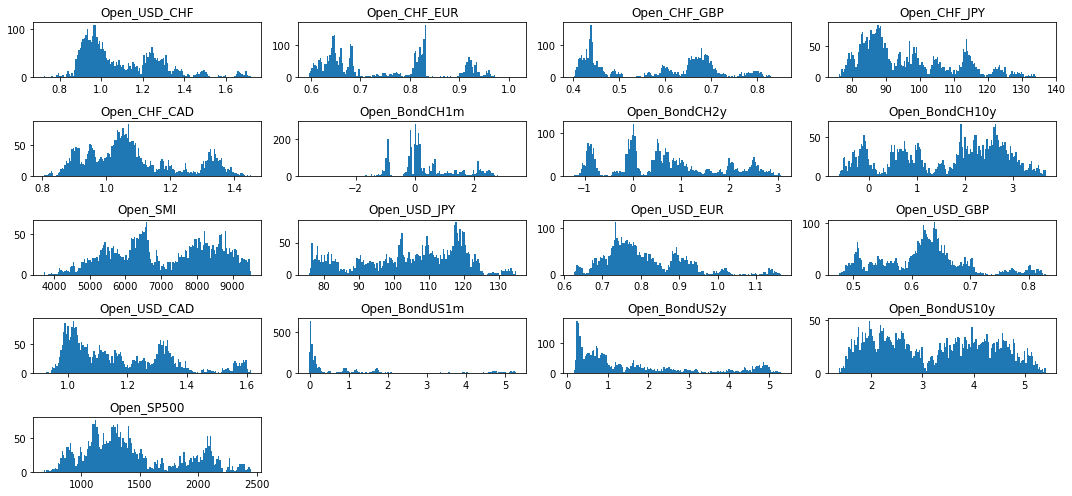

In [2086]:
data = []
for i in df.columns[1:]:
    data.append(df[i])

fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

205
66
42
Shape:             
X train     (2708, 4, 17), y train     (2708, 17)            
X train val (301, 4, 17) , y train val (301, 17)             
X test      (532, 4, 17) , y test      (532, 17)


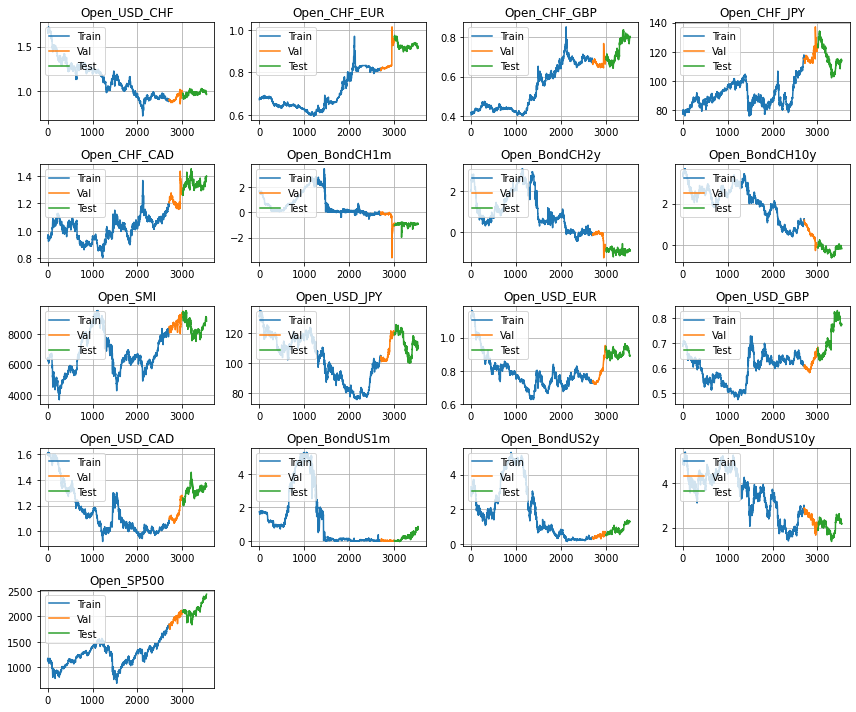

In [2087]:
device = 'cpu'
LOOKBACK = 4

train_x, val_x, test_x, train_y, val_y, test_y, norm, price= pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  trend_=True,
  span_trend_=4,
  span_back_trend_= 0,
  tresh=0.0,
  norm_=True,

  fraction_val_=0.1,
  fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(5, 4,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

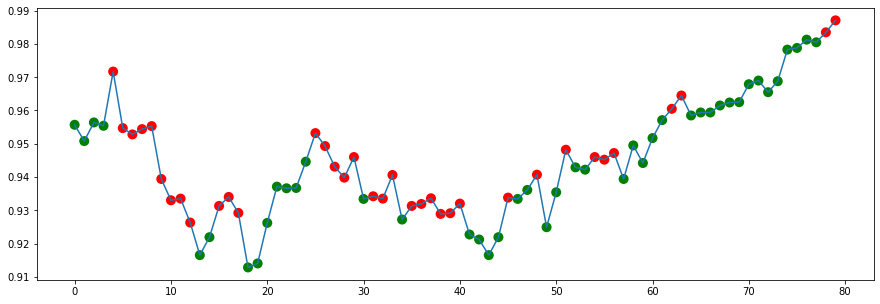

In [2088]:
end = 80#300 l2
colors = {0:'red', 1:'green'}
plt.figure(figsize=(15,5))


plt.scatter(np.arange(end), price[l2:l2+ end ], c=pd.Series(test_y[:end,0]).map(colors).values, s=100, lw=0)
plt.plot(np.arange(end), price[l2:l2+ end ])


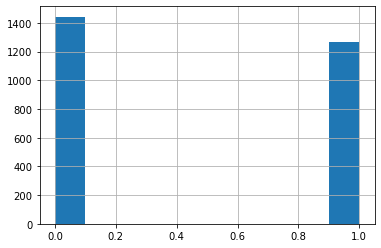

In [2089]:
plt.hist(train_y[:,0], )
plt.grid()
plt.show()

In [2090]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y[np.isnan(train_y)] , val_y[np.isnan(val_y)], test_y[np.isnan(test_y)] 

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

In [2091]:
train_x_fin  = pp.add_label_data(train_x, train_y)
val_x_fin  = pp.add_label_data(val_x, val_y)
test_x_fin  = pp.add_label_data(test_x, test_y)

span = train_x.shape[1]

train_y_fin  = train_y[span:]
val_y_fin  = val_y[span:]
test_y_fin  = test_y[span:]

# Trend Prediction

In [2092]:
buff = train_y[:,0] #np.argmax(train_y[:, :, 0], axis=1)

'''
positive_weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)

buff = train_y[:, 0]
buff.sum()/len(buff)


sum = len(buff[buff == 0]) +len(buff[buff == 1]) + len(buff[buff == 2]) + len(buff[buff == 3])
weight = torch.tensor([(len(buff[buff == 0])/sum), (len(buff[buff == 1])/sum), len(buff[buff == 2])/sum, len(buff[buff == 3])/sum]).float().to(device)

'''


x = torch.randn(20, 5) 
y = torch.randint(0, 5, (20,)) # classes
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(buff), y= buff)
#class_weights[2] -= 0.4
#class_weights[3] -= 0.4
weight=torch.tensor(class_weights,dtype=torch.float)
 

weight = torch.tensor(
        len(buff[buff == 0.0]) / len(buff[buff == 1.0])
    ).float().to(device)

### GRU 1-feature 

In [738]:
model_gru_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_1.to(device)
model_gru_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): Sigmoid()
)

100%|██████████| 15/15 [00:00<00:00, 29.48it/s]


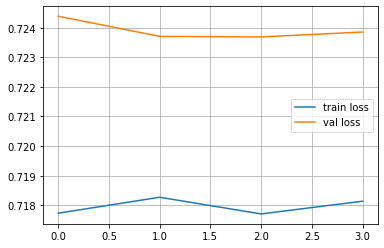

In [740]:
lr= 0.001
num_epochs= 15

train_loss, val_loss = pl.train(
    model=model_gru_1,
    train_x_ = train_x[:,:,0].reshape(-1, LOOKBACK, 1),
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x[:,:,0].reshape(-1, LOOKBACK, 1),
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [741]:
out_base, tar, ACC_gru_1 = pl.evaluate_trend(model_gru_1, val_x[:,:,0].reshape(-1, LOOKBACK,1), val_y[:, 0], device="cpu", verbose=1)


ACC:  0.55298
nb 0 = 191; nb 1 = 111  nb 2 = 0


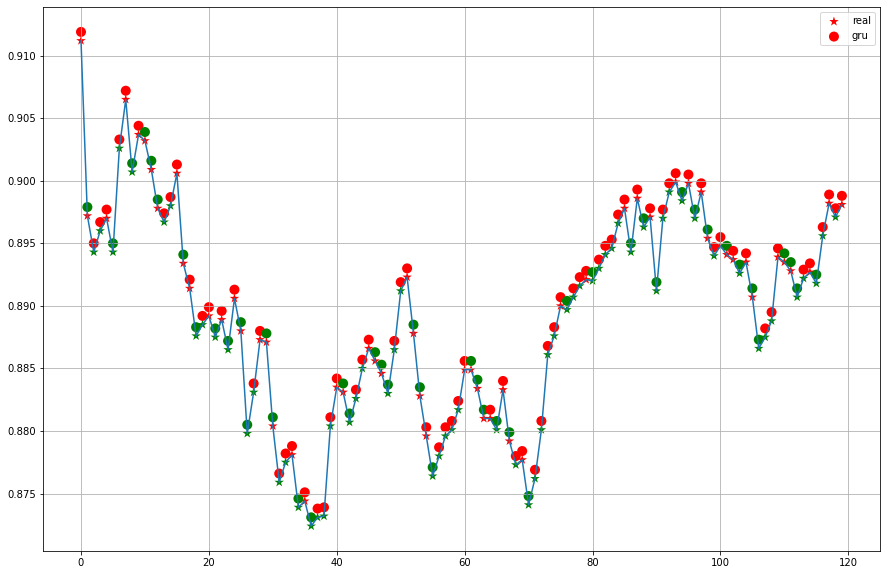

In [743]:
end = 120#300 l2
colors = {0:'red', 1:'green'}

plt.figure(figsize=(15,10))

plt.scatter(np.arange(end), price[l1:l1+end],marker='*', c=pd.Series(tar[:end]).map(colors).values, s=100, lw=0, label="real")
plt.scatter(np.arange(end), np.array(price[l1:l1+end])+0.0007, c=pd.Series(out_base[:end]).map(colors).values, s=100, lw=0,  label="gru")
plt.plot(np.arange(end), price[l1:l1+end])
plt.grid()
plt.legend()



### GRU 17-feature

In [1877]:
model_gru_17 = ml.GRU_base(
        hidden_size=3,
        num_layers=2,
        input_size=17*2,
        out_features_lin=3,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_17.to(device)
model_gru_17

GRU_base(
  (gru): GRU(34, 3, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=3, out_features=3, bias=True)
  (fc1_bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=3, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 40%|████      | 4/10 [00:00<00:00, 16.33it/s]

Epoch: 2/10
MSE = [train loss mean :  0.71258197] , [val loss mean:  0.74083984, MSE (last) 74.04667%]
Epoch: 4/10
MSE = [train loss mean :  0.71192558] , [val loss mean:  0.73989835, MSE (last) 73.98295%]


 80%|████████  | 8/10 [00:00<00:00, 15.50it/s]

Epoch: 6/10
MSE = [train loss mean :  0.71093209] , [val loss mean:  0.74018946, MSE (last) 74.01311%]
Epoch: 8/10
MSE = [train loss mean :  0.70947492] , [val loss mean:  0.74031910, MSE (last) 74.03494%]


100%|██████████| 10/10 [00:00<00:00, 15.85it/s]


Epoch: 10/10
MSE = [train loss mean :  0.71057367] , [val loss mean:  0.74041781, MSE (last) 74.06029%]


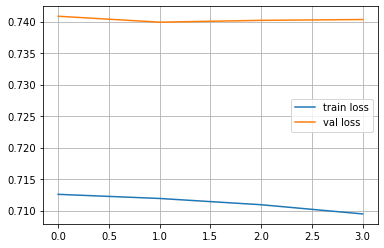

In [1884]:
lr= 0.001
num_epochs= 10

train_loss, val_loss = pl.train(
    model=model_gru_17,
    train_x_ = train_x_fin,
    train_y_ = train_y_fin[:,0].reshape(-1,1),
    val_x_ = val_x_fin,
    val_y_= val_y_fin[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=weight),#(pos_weight=positive_weight),
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [1856]:
test_x_fin.shape, test_y_fin[:,0].shape

((528, 4, 34), (528,))

In [1885]:
out_base5, tar, ACC_gru_17 = pl.evaluate_trend(model_gru_17, test_x_fin, test_y_fin[:,0].reshape(-1,1), device="cpu", verbose=1)


(524,) (524,)
ACC:  0.49237
nb 0 = 322; nb 1 = 202; nb 2 = 0; nb 3 = 0


0.5343511450381679

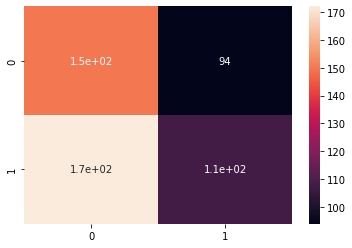

In [1886]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(data=confusion_matrix(tar, out_base5), annot=True)
plt.plot()
np.mean(tar == 1)

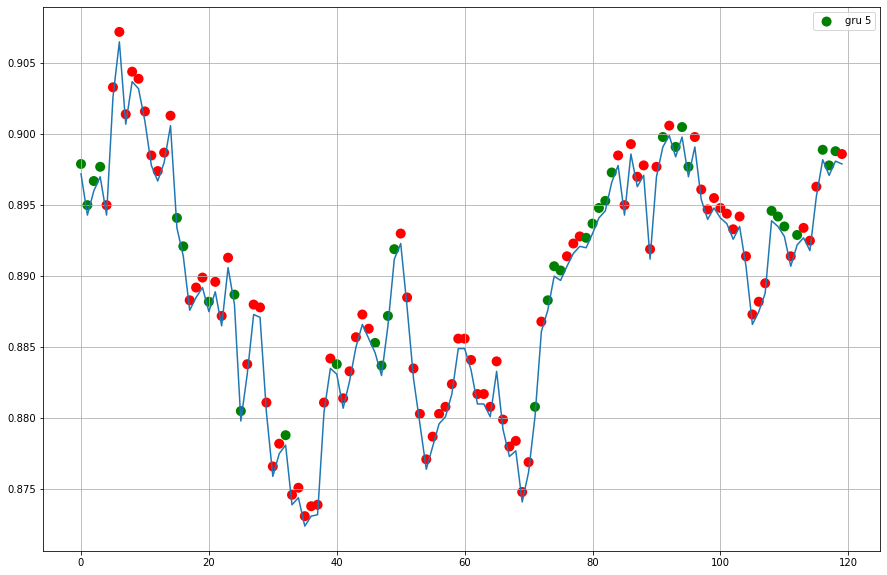

In [1887]:
end = 120#300 l2
colors = {0:'red', 1:'green'}

plt.figure(figsize=(15,10))

#plt.scatter(np.arange(end), price[l1:l1+end],marker='*', c=pd.Series(tar[:end]).map(colors).values, s=100, lw=0, label="real")
plt.scatter(np.arange(end), np.array(price[l1:l1+end])+0.0007, c=pd.Series(out_base5[:end]).map(colors).values, s=100, lw=0,  label="gru 5")
plt.plot(np.arange(end), price[l1:l1+end])
plt.grid()
plt.legend()


### GRU + Auto-Encoder 1-feature 

In [227]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.load_state_dict(torch.load('Helper/model/model_autoenc_1.pth'))
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [240]:
model_gru_autoenc_1 = ml.GRU_base(
        hidden_size=8,
        num_layers=1,
        input_size=1,
        out_features_lin=8,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_1.to(device)
model_gru_autoenc_1

GRU_base(
  (gru): GRU(1, 8, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=8, out_features=8, bias=True)
  (fc1_bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

100%|██████████| 40/40 [00:02<00:00, 18.15it/s]


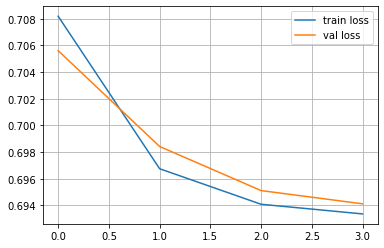

In [241]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp1.to(device).float())
train_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp2.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

lr= 0.001
num_epochs= 40

train_loss, val_loss = pl.train(
    model=model_gru_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [242]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out = model_autoenc_1(inp3.to(device).float())
val_x_smooth = out.cpu().detach().numpy().reshape(-1, LOOKBACK, 1)

_, _, ACC_gru_autoenc_1 = pl.evaluate_trend(model_gru_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53525
nb 0 = 166; nb 1 = 217


### Dense + latent space Auto-Encoder 1-feature 

In [279]:
model_dense_autoenc_1 = ml.Dense(
    num_layers=2,
    layer_size=8,
    input_size=3,
    output_size=1,
    dropout=0.05
    )
model_dense_autoenc_1.to(device)
model_dense_autoenc_1

Dense(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
)

100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


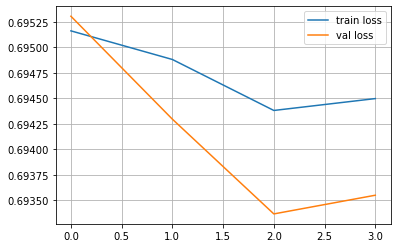

In [284]:
model_autoenc_1.eval()
inp1 = torch.from_numpy(train_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

inp2 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out, latent = model_autoenc_1(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)

lr= 0.001
num_epochs= 25 

train_loss, val_loss = pl.train(
    model=model_dense_autoenc_1,
    train_x_ = train_x_smooth,
    train_y_ = train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y[:,0].reshape(-1,1),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(pos_weight=positive_weight),
    device_=device,
    verbose = 0)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [375]:
inp3 = torch.from_numpy(val_x[:,:,0].reshape(-1, 1, LOOKBACK))
out,latent = model_autoenc_1(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)

_, _, ACC_dense_autoenc_1 = pl.evaluate_trend(model_dense_autoenc_1, val_x_smooth, val_y[:, 0], device="cpu", verbose=1)


ACC:  0.53786
nb 0 = 173; nb 1 = 210


### GRU + Auto-Encoder 17-feature 

In [2093]:
model_autoenc_17 = ml.auto_encoder(input_size=17*2,
    nb_channel_conv=8)
model_autoenc_17.load_state_dict(torch.load('Helper/model/model_autoenc_17.pth'))
model_autoenc_17.to(device)
model_autoenc_17

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(34, 8, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv3_t): ConvTranspose1d(8, 34, kernel_size=(2,), stride=(1,))
)

In [2094]:
model_gru_autoenc_17 = ml.GRU_base(
        hidden_size=16,
        num_layers=2,
        input_size=17*2,
        out_features_lin=16,
        out_features_end=1,
        dropout=0.05,
        device=device)
model_gru_autoenc_17.to(device)
model_gru_autoenc_17

GRU_base(
  (gru): GRU(34, 16, num_layers=2, batch_first=True, dropout=0.05)
  (fc0_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_0): Linear(in_features=16, out_features=16, bias=True)
  (fc1_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_1): Linear(in_features=16, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

 20%|██        | 201/1000 [00:14<00:58, 13.54it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.77670787] , [val loss mean:  0.76204989, MSE (last) 74.71626%]


 40%|████      | 401/1000 [00:30<00:45, 13.27it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.75874485] , [val loss mean:  0.74321504, MSE (last) 74.09683%]


 60%|██████    | 601/1000 [00:46<00:30, 13.12it/s]

Epoch: 600/1000
MSE = [train loss mean :  0.75179044] , [val loss mean:  0.74033244, MSE (last) 73.96680%]


 80%|████████  | 801/1000 [01:01<00:15, 13.18it/s]

Epoch: 800/1000
MSE = [train loss mean :  0.74656480] , [val loss mean:  0.73862135, MSE (last) 73.77182%]


100%|██████████| 1000/1000 [01:17<00:00, 12.92it/s]


Epoch: 1000/1000
MSE = [train loss mean :  0.74352761] , [val loss mean:  0.73726435, MSE (last) 73.59115%]


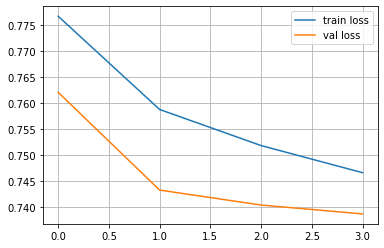

In [2095]:
model_autoenc_17.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x_fin,1,2))
out = model_autoenc_17(inp1.to(device).float())
train_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

inp2 = torch.from_numpy(np.swapaxes(val_x_fin,1,2))
out = model_autoenc_17(inp2.to(device).float())
val_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

'''
a = train_y[:,0].astype(int)
train_y_ = np.zeros((a.size, int(a.max()) + 1))
train_y_[np.arange(a.size), a.astype(int)] = 1

a = val_y[:,0].astype(int)
val_y_ = np.zeros((a.size, int(a.max()) + 1))
val_y_[np.arange(a.size), a.astype(int)] = 1
'''

lr= 0.00001
num_epochs= 1000


train_loss, val_loss = pl.train(
    model=model_gru_autoenc_17,
    train_x_ = train_x_smooth,
    train_y_ = train_y_fin[:,0].reshape(-1, 1),#train_y[:,:,0].reshape(-1,3),
    val_x_ = val_x_smooth,
    val_y_= val_y_fin[:,0].reshape(-1, 1), #val_y[:,:,0].reshape(-1,3),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.BCEWithLogitsLoss(weight=weight), #nn.BCEWithLogitsLoss(pos_weight=positive_weight), #nn.CrossEntropyLoss(weight=weight),
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()


In [2096]:
inp3 = torch.from_numpy(np.swapaxes(test_x_fin,1,2))
out = model_autoenc_17(inp3.to(device).float())
test_x_smooth = np.swapaxes(out.cpu().detach().numpy(),2,1)

'''
a = val_y[:,0].astype(int)
val_y_ = np.zeros((a.size, int(a.max()) + 1))
val_y_[np.arange(a.size), a.astype(int)] = 1
'''

out_enc_gru, tar, ACC_gru_autoenc_17 = pl.evaluate_trend(model_gru_autoenc_17, test_x_smooth, test_y_fin[:,0].reshape(-1, 1), device="cpu", verbose=1)


(528,) (528,)
ACC:  0.63636
nb 0 = 307; nb 1 = 221; nb 2 = 0; nb 3 = 0


In [2097]:
np.mean(tar == 1)

0.5170454545454546

0.5170454545454546

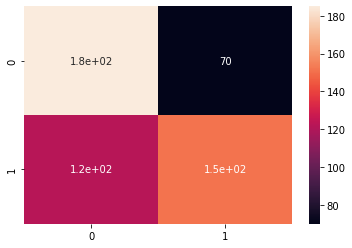

In [2099]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(data=confusion_matrix(tar, out_enc_gru), annot=True)
plt.plot()
np.mean(tar == 1)

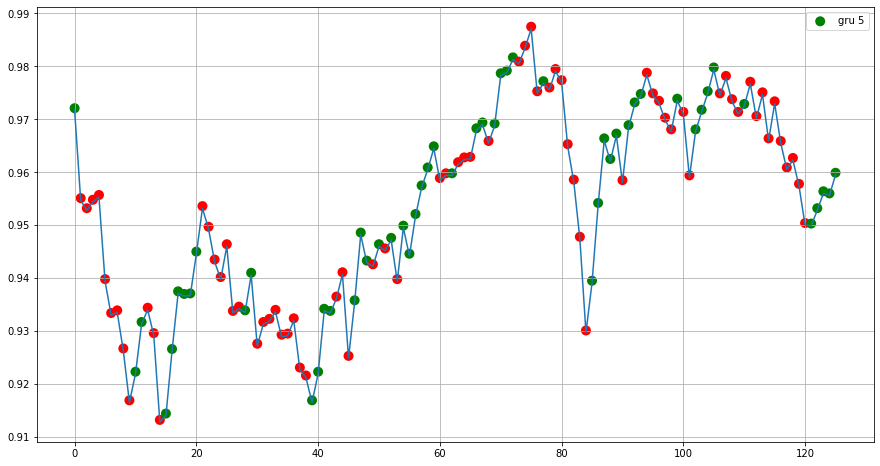

In [2100]:
end = 130#300 l2
colors = {0:'red', 1:'green', 2:"blue", 3:"orange"}

plt.figure(figsize=(15,8))

plt.scatter(np.arange(end-span), np.array(price[l2+span:l2+end])+0.0004, c=pd.Series(out_enc_gru[:end-span]).map(colors).values, s=100, lw=0,  label="gru 5")
#plt.scatter(np.arange(end-span), price[l2+span:l2+end],marker='*', c=pd.Series(tar[:end-span]).map(colors).values, s=100, lw=0, label="real")

plt.plot(np.arange(end-span), price[l2+span:l2+end])
plt.grid()
plt.legend()


price =  0.9717 [ TIME:  0  ]
gain =  -2.044041568899843 % [ TIME:  1  ]
portfolio=  997.9559584311002
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.9219 [ TIME:  10  ]
gain =  1.0087972122790063 % [ TIME:  12  ]
portfolio=  998.9647556433791
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.914 [ TIME:  15  ]
gain =  3.9762083916849207 % [ TIME:  21  ]
portfolio=  1002.9409640350641
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 
price =  0.9335 [ TIME:  28  ]
gain =  -0.9726313658275103 % [ TIME:  30  ]
portfolio=  1001.9683326692366
-- -- -- -- -- -- -- -- -- -- -- -- -- -- 


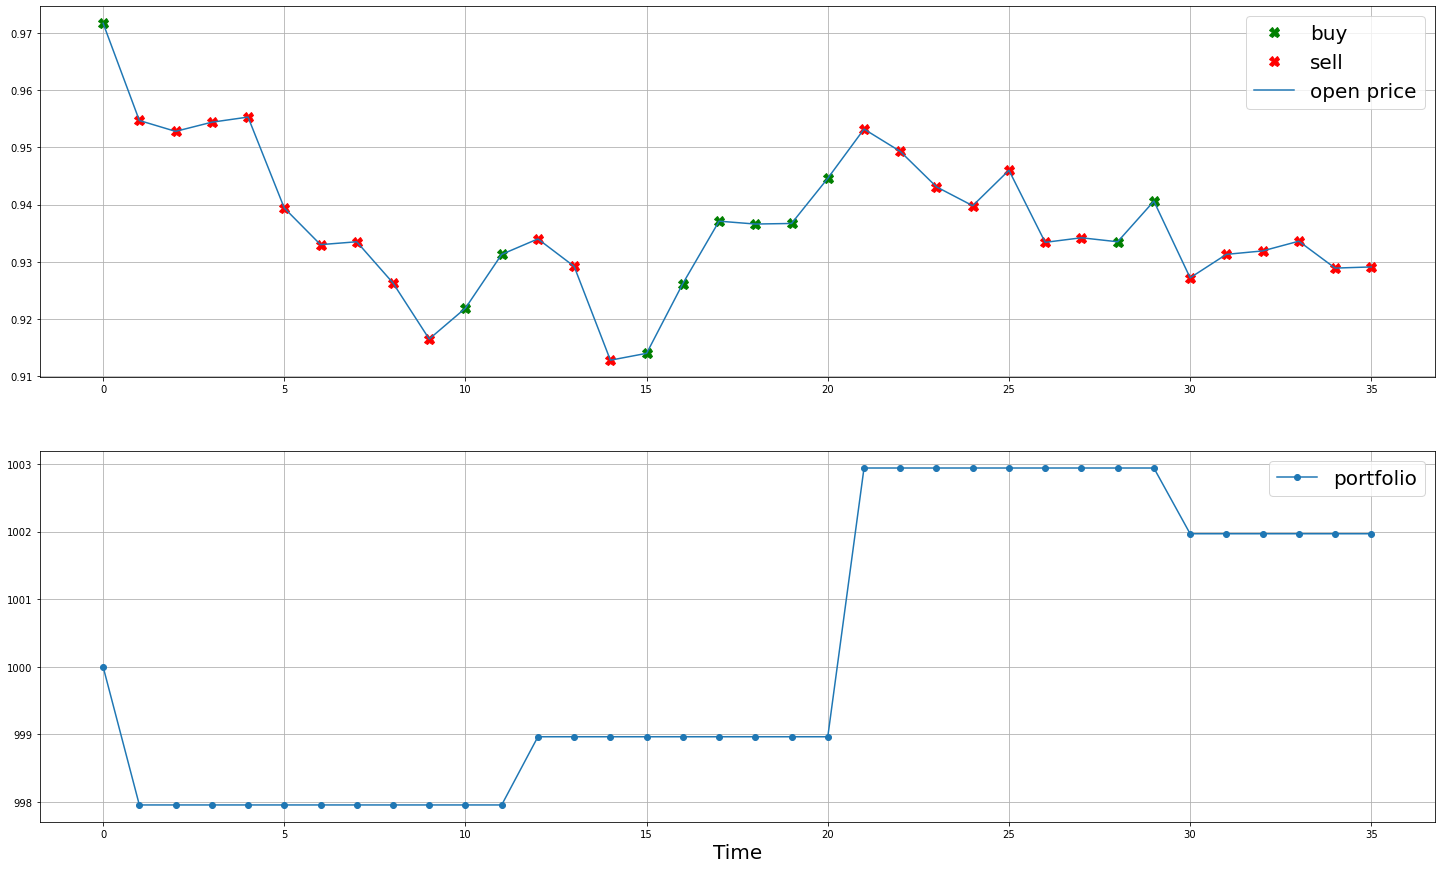

In [2102]:
end = 40
label = out_enc_gru[:end-span]
p = price[l2+span:l2+end]
time = np.arange(len(label))

buy = []
buy_t = []
sell = []
sell_t = []

trade = False 
portfolio = 1000
portfolio_list = []
usd = 0

tax = 0.9985

for i in range(len(label)): 
  if label[i] == 1:
    if trade == False:
      portfolio -= 100
      usd += 100*tax/p[i]
      print("price = ", p[i], "[ TIME: ", i," ]")
      trade= True 


    buy.append(p[i])
    buy_t.append(i)
    
  else:
    if trade == True: 
      print("gain = ", (usd*p[i]*tax)-100,"%", "[ TIME: ", i," ]")
      portfolio += usd*p[i]*tax
      print("portfolio= ", portfolio)
      usd = 0
      trade= False
      print("-- -- -- -- -- -- -- -- -- -- -- -- -- -- ")
      count = 0
    sell.append(p[i])
    sell_t.append(i)

  if trade == False:  
    portfolio_list.append(portfolio)
  else:
    portfolio_list.append(portfolio+100)

plt.figure(figsize=(25, 15)) 

plt.subplot(2, 1, 1)
plt.plot(buy_t, buy,marker="X", markersize=10, linestyle = 'None',color='green', label='buy')
plt.plot(sell_t,sell,marker="X", markersize=10,linestyle = 'None',color='red', label='sell')
plt.plot(time, p,label="open price")
plt.grid(True)
plt.legend(fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(time, portfolio_list,'o-',label="portfolio")
plt.grid(True)
plt.legend(fontsize=20)

plt.xlabel("Time", fontsize=20)
plt.show()

In [2064]:
torch.save(model_gru_autoenc_17.cpu().state_dict(), 'Helper/model/model_trend_17.pth')

### Dense + latent space Auto-Encoder 17-feature 

In [1251]:
model_dense_autoenc_17 = ml.Dense(
    num_layers=4,
    layer_size=64,
    input_size=6,
    output_size=4,
    dropout=0.05
    )
model_dense_autoenc_17.to(device)
model_dense_autoenc_17

Dense(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.05, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.05, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=4, bias=True)
  )
)

 24%|██▍       | 12/50 [00:00<00:02, 16.45it/s]

Epoch: 10/50
MSE = [train loss mean :  1.18060183] , [val loss mean:  1.21622630, MSE (last) 121.78253%]


 44%|████▍     | 22/50 [00:01<00:01, 16.46it/s]

Epoch: 20/50
MSE = [train loss mean :  1.17566758] , [val loss mean:  1.21411449, MSE (last) 121.33873%]


 64%|██████▍   | 32/50 [00:01<00:01, 15.47it/s]

Epoch: 30/50
MSE = [train loss mean :  1.17228863] , [val loss mean:  1.21230752, MSE (last) 121.27928%]


 84%|████████▍ | 42/50 [00:02<00:00, 16.51it/s]

Epoch: 40/50
MSE = [train loss mean :  1.17111088] , [val loss mean:  1.21331422, MSE (last) 121.23383%]


100%|██████████| 50/50 [00:03<00:00, 16.33it/s]


Epoch: 50/50
MSE = [train loss mean :  1.16882569] , [val loss mean:  1.21291658, MSE (last) 121.24429%]


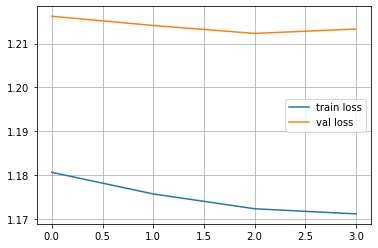

In [1256]:
model_autoenc_17.eval()
inp1 = torch.from_numpy(np.swapaxes(train_x,1,2))
out, latent = model_autoenc_17(inp1.to(device).float(), return_latent=True)
train_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)


train_x_smooth = np.concatenate((train_x_smooth, train_x_smooth*train_x_smooth), axis=1)


inp2 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_17(inp2.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1, 3)
val_x_smooth = np.concatenate((val_x_smooth, val_x_smooth*val_x_smooth), axis=1)



lr= 0.0001
num_epochs= 50

a = train_y[:,0].astype(int)
train_y_ = np.zeros((a.size, int(a.max()) + 1))
train_y_[np.arange(a.size), a.astype(int)] = 1

a = val_y[:,0].astype(int)
val_y_ = np.zeros((a.size, int(a.max()) + 1))
val_y_[np.arange(a.size), a.astype(int)] = 1




train_loss, val_loss = pl.train(
    model=model_dense_autoenc_17,
    train_x_ = train_x_smooth,
    train_y_ = train_y_, #train_y[:,0].reshape(-1,1),
    val_x_ = val_x_smooth,
    val_y_= val_y_,#val_y[:,0].reshape(-1,1),
    batch_size_=256,
    num_epochs_=num_epochs,
    lr_=lr,
    criterion_ = nn.CrossEntropyLoss(weight=weight), #nn.BCEWithLogitsLoss(pos_weight=positive_weight), #nn.CrossEntropyLoss(weight=weight),
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/5)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

In [1257]:
inp3 = torch.from_numpy(np.swapaxes(val_x,1,2))
out, latent = model_autoenc_17(inp3.to(device).float(), return_latent=True)
val_x_smooth = latent.cpu().detach().numpy().reshape(-1,3)
val_x_smooth = np.concatenate((val_x_smooth, val_x_smooth*val_x_smooth), axis=1)


a = val_y[:,0].astype(int)
val_y_ = np.zeros((a.size, int(a.max()) + 1))
val_y_[np.arange(a.size), a.astype(int)] = 1


out_enc_dense, tar, ACC_dense_autoenc_17 = pl.evaluate_trend(model_dense_autoenc_17, val_x_smooth, val_y_, device="cpu", verbose=1)


tensor([[-1.2104e-03,  1.6746e-01, -2.9981e-01, -1.6219e-01],
        [ 1.1189e+00, -1.3949e-01,  2.1209e+00, -3.1722e+00],
        [ 3.0743e-01, -3.0727e-01,  8.0904e-01, -9.4356e-01],
        [ 3.0651e-01,  2.5156e-01, -4.2100e-01,  1.2445e-01]],
       grad_fn=<SliceBackward0>)
(302,) (302,)
ACC:  0.38079
nb 0 = 20; nb 1 = 75; nb 2 = 100; nb 3 = 100


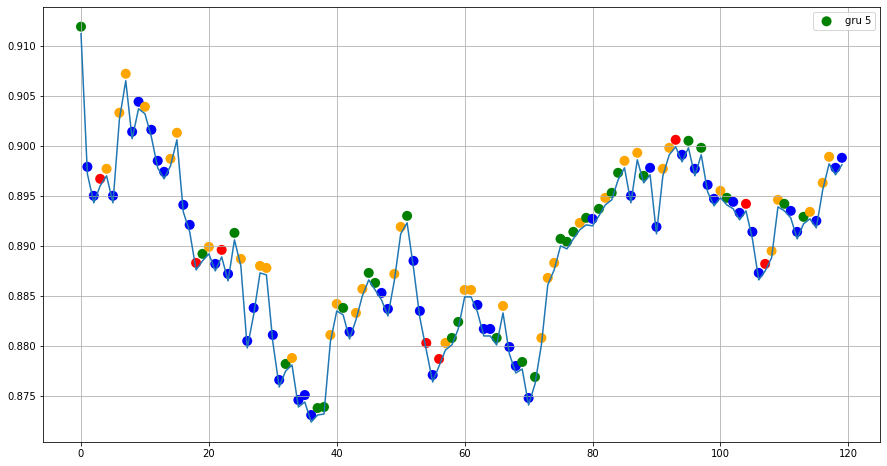

In [1258]:
end = 120#300 l2
colors = {0:'red', 1:'green', 2:"blue", 3: "orange"}

plt.figure(figsize=(15,8))

#plt.scatter(np.arange(end), price[l1:l1+end],marker='*', c=pd.Series(tar[:end]).map(colors).values, s=100, lw=0, label="real")
plt.scatter(np.arange(end), np.array(price[l1:l1+end])+0.0007, c=pd.Series(out_enc_dense[:end]).map(colors).values, s=100, lw=0,  label="gru 5")
plt.plot(np.arange(end), price[l1:l1+end])
plt.grid()
plt.legend()


### Result 

In [1522]:
print(f"ACC GRU 1-feature:                             { ACC_gru_1: 0.08f}")
print(f"ACC GRU 17-features:                            { ACC_gru_17: 0.08f}")
#print(f"ACC GRU Auto-Encoder 1-feature:                { ACC_gru_autoenc_1: 0.08f}")
#print(f"ACC Dense latent space Auto-Encoder 1-feature: { ACC_dense_autoenc_1: 0.08f}")
print(f"ACC GRU Auto-Encoder 17-feature:                { ACC_gru_autoenc_17: 0.08f}")
print(f"ACC Dense latent space Auto-Encoder 17-feature: { ACC_dense_autoenc_17: 0.08f}")


ACC GRU 1-feature:                              0.55298013
ACC GRU 17-features:                             0.51986755
ACC GRU Auto-Encoder 17-feature:                 0.29235880
ACC Dense latent space Auto-Encoder 17-feature:  0.38079470
